Load the necessary packages

In [15]:
import pandas as pd
import yfinance as yf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from math import sqrt

load the data

In [7]:
data=pd.read_csv('data/DJIA.csv')
data['Date'] = pd.to_datetime(data['Date'])
data["log"]=np.log(data['Close'])
# Set 'Date' as the index
data.set_index('Date', inplace=True)
data['Log_diff'] = data['log'].diff()

visualize

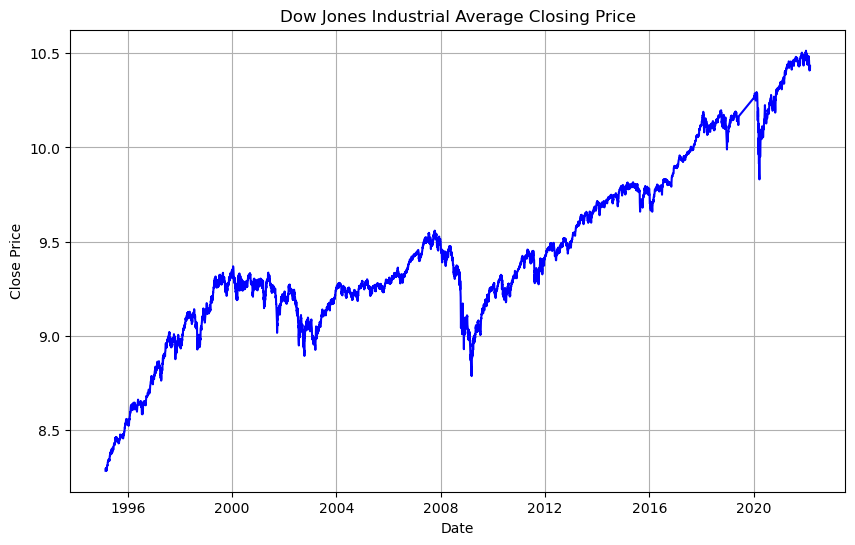

In [8]:
# Plot the 'Close' column
plt.figure(figsize=(10,6))
plt.plot(data["log"], color='blue')
#plt.plot(data['Close'], color='red')
plt.title('Dow Jones Industrial Average Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

check the data's stationarity, and whetehr it has the missing value

In [9]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

stationarity_test_results = test_stationarity(data['log'])
missing_values = data['log'].isnull().sum()

missing_values, stationarity_test_results

(0,
 Test Statistic                   -1.084256
 p-value                           0.721309
 #Lags Used                       34.000000
 Number of Observations Used    6599.000000
 Critical Value (1%)              -3.431341
 Critical Value (5%)              -2.861978
 Critical Value (10%)             -2.567003
 dtype: float64)

In [11]:
# Perform Augmented Dickey-Fuller test
result = adfuller(data['Log_diff'])

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -15.609487945550121
p-value: 1.787274593596916e-28
Critical Values:
   1%: -3.4313413389214773
   5%: -2.8619780879726986
   10%: -2.5670031907365596


d:\codesupport\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


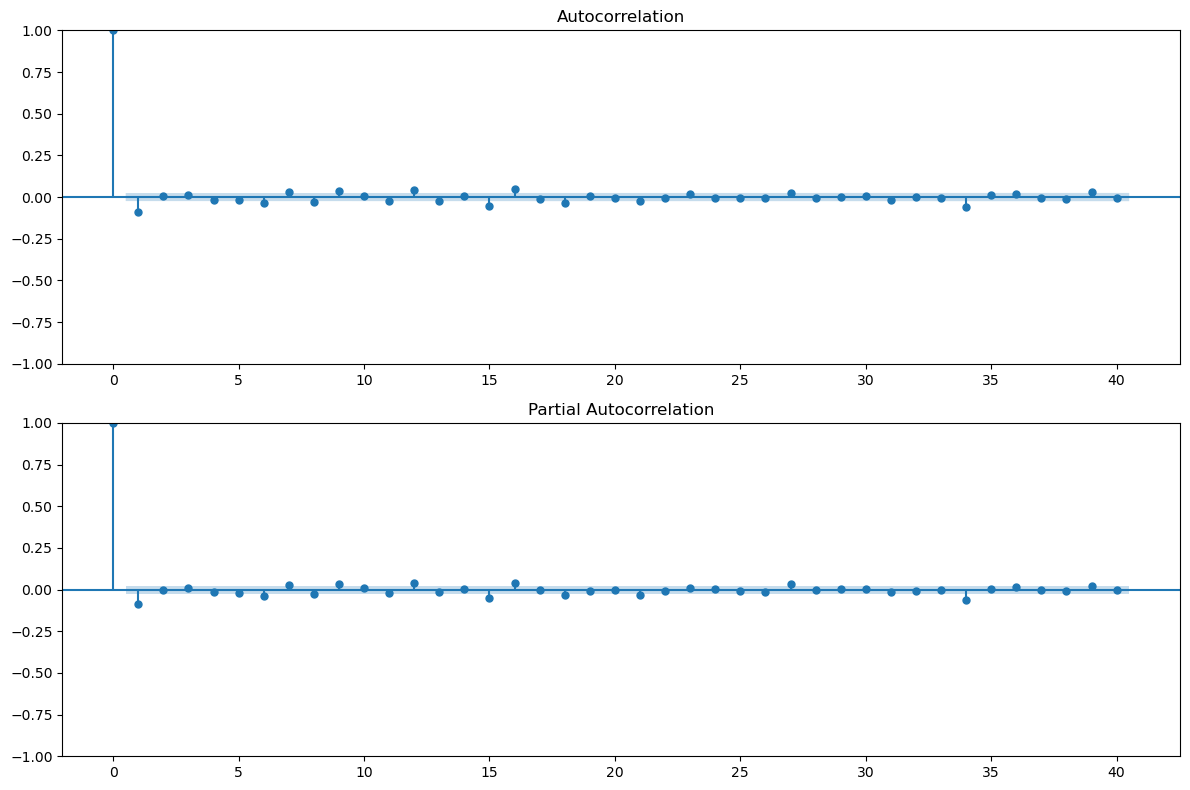

In [12]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF
plot_acf(data['Log_diff'], lags=40, ax=ax[0])

# Plot PACF
plot_pacf(data['Log_diff'], lags=40, ax=ax[1])

plt.tight_layout()
plt.show()

d:\codesupport\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\codesupport\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\codesupport\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


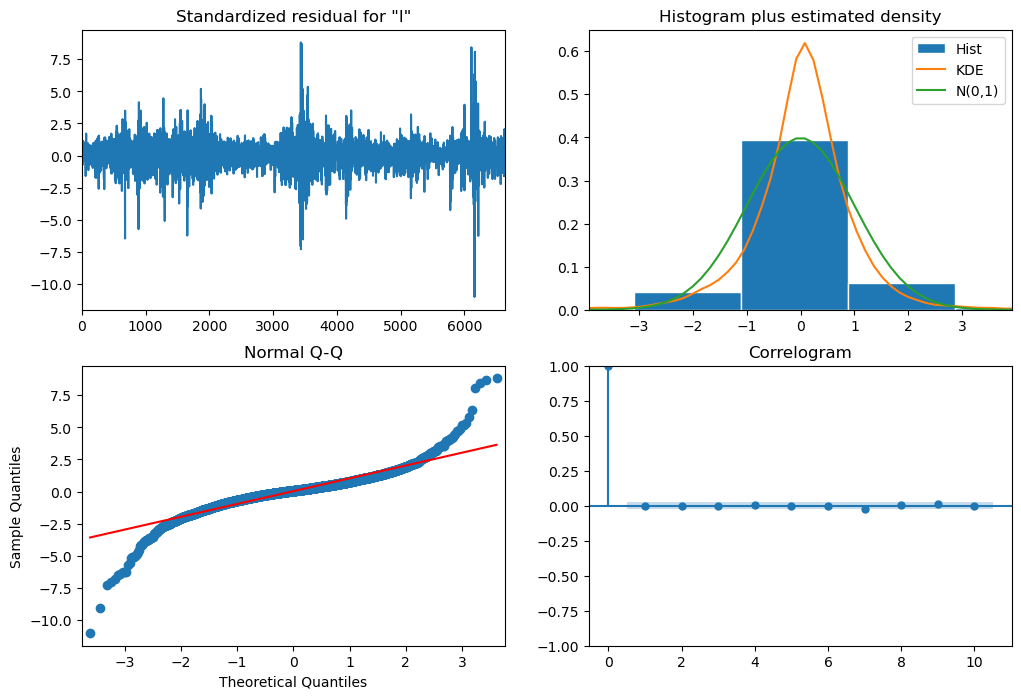

In [5]:
# Define the model
model = ARIMA(data['log'], order=(6, 1, 6))

# Fit the model
arima_result = model.fit()

# Plot the diagnostic plots
arima_result.plot_diagnostics(figsize=(12, 8))
plt.show()

In [16]:
arima_result.aic

-40175.8073060648

In [9]:
def calculate_aic(order):
    model = ARIMA(data['log'], order=order)
    result = model.fit()
    return result.aic

# Define the orders to try
orders = [(6, 1, 6), (5, 1, 5), (7, 1, 7), (6, 1, 5), (5, 1, 6)]

# Calculate the AIC for each order
aic_values = {order: calculate_aic(order) for order in orders}

aic_values

d:\codesupport\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\codesupport\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\codesupport\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\codesupport\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

{(6, 1, 6): -40175.8073060648,
 (5, 1, 5): -40160.60666651802,
 (7, 1, 7): -40163.99111056325,
 (6, 1, 5): -40166.786464797406,
 (5, 1, 6): -40163.84210390771}

6,1,6 is the best

对单个窗口进行检验

In [16]:
# Removing the first row (NA value in Log_diff)
data = data.iloc[1:]
order=(6,1,6)
window = int(len(data) * 0.8)
def evaluate_arima_model_single(order, train_size):
    train, test = data['Log_diff'][0:train_size], data['Log_diff'][train_size:]
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test)).values
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

# Evaluating the model for the single time window
rmse_result = evaluate_arima_model_single(order, window)
rmse_result

d:\codesupport\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\codesupport\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\codesupport\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\codesupport\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\codesupport\anaco

0.012860860503327864

In [17]:
start_date = '2010-01-01'
end_date = '2020-01-01'
window_data = data[start_date:end_date]